# 非線形ARモデルの係数をstatsのARで推定してみる

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

### 非線形ARモデルに従う時系列の作成

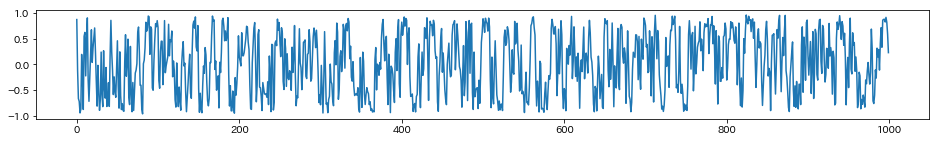

In [3]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', sigma=1/np.sqrt(3))
inno = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', return_innovation=True, sigma=1/np.sqrt(3))
# 描画
plt.figure(figsize=(16,2)) ; plt.plot(data) ; plt.show()

### 推定に用いる$\hat p$を決定

In [5]:
hat_p = 4

### 学習

In [6]:
from statsmodels.tsa.ar_model import AutoReg
result = AutoReg(data, lags = hat_p).fit()
result.params[1:]

array([ 0.7335, -0.3459,  0.4781, -0.2548])

In [7]:
phi_a

[1.0, -0.5, 0.7, -0.4]

### テスト

In [12]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=2**32-1
N = 100
testData = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', sigma=1/np.sqrt(3))
test_inno = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', return_innovation=True, sigma=1/np.sqrt(3))

In [35]:
params = result.params[1:]
test_estimate_inno = []
for i in range(p,N):
    test_estimate_inno.append( testData[i] - (params*np.flip(testData[i-p:i])).sum() + result.params[0])
test_estimate_inno = np.array(test_estimate_inno)

In [36]:
((test_estimate_inno - test_inno[4:])**2).mean()

0.03434501516482982

Text(0.5, 1.0, 'mse=0.03434501516482982, aae=0.13509822287723966')

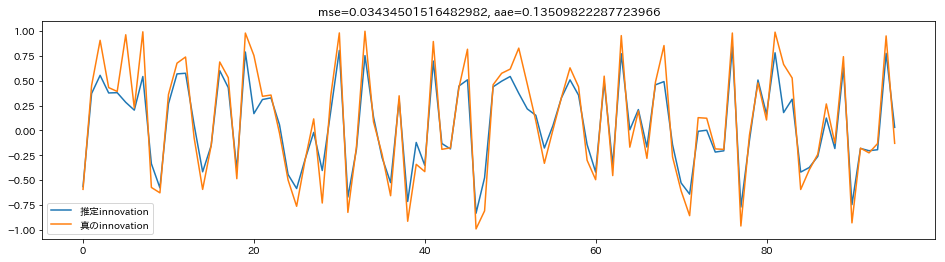

In [38]:
plt.figure(figsize=(16,4))
plt.plot(test_estimate_inno, label='推定innovation')
plt.plot(test_inno[4:], label='真のinnovation')
plt.legend()
plt.title("mse={0}, aae={1}".format(((test_estimate_inno - test_inno[4:])**2).mean(),( np.abs(test_estimate_inno - test_inno[4:])).mean()))